In [270]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LogisticRegression
from IPython.display import display, Markdown, Latex
sns.set_palette("flare_r")

def ConcordantRatio(y_test_pred, y_test):
    i = (y_test * (1-y_test_pred)) + ((1-y_test) * (y_test_pred))
    concordant = i < (np.max(y_test_pred)/2)
    return np.mean(concordant)

def caio_roc_curve(y_real, y_proba, deciles):
    sensitivity = []
    specificity = []
    precision = []
    threshold = []
    f1 = []

    for i in deciles:
        cutoff = i
        p = y_proba > cutoff

        metrics = ClassificationMetrics(p, y_real)

        sensitivity.append(metrics["recall"]) #same as recall
        specificity.append(metrics["specificity"])
        precision.append(metrics["precision"])
        f1.append(metrics["f1"])
        threshold.append(cutoff)

    return sensitivity, specificity, precision, f1, threshold


def ResidualMetrics(y_pred, y_real, y_benchmark = None):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
    
    MSE = mean_squared_error(y_pred, y_real)
    MAE = mean_absolute_error(y_pred, y_real)
    MSLE = mean_squared_log_error(y_pred, y_real)
    RMSE = np.sqrt(MSE)
    RMSLE = np.sqrt(MSLE)
    R2 = r2_score(y_pred, y_real)
    R2_benchmark = None
    
    if(y_benchmark is not None):
        R2_benchmark = mean_squared_error(y_pred,y_real) / mean_squared_error(y_benchmark,y_real)
        
    return {
        "MSE":MSE,
        "MAE":MAE,
        "MSLE":MSLE,
        "RMSE":RMSE,
        "RMSLE":RMSLE,
        "R2":R2,
        "R2_BENCH":R2_benchmark
    }


def ClassificationMetrics(y_pred,y_real):
    tp = np.sum((y_pred == 1) & (y_real == 1))
    tn = np.sum((y_pred == 0) & (y_real == 0))
    fn = np.sum((y_pred == 0) & (y_real == 1))
    fp = np.sum((y_pred == 1) & (y_real == 0))
    recall = tp / (tp + fn)
    specificity = fp / (fp + tn)
    precision =tp / (tp + fp)
    f1 = 2 * ((precision*recall) / (precision+recall))

    return {
        "recall":recall,
        "specificity":specificity,
        "precision":precision,
        "f1":f1
    }


def ModelMetrics(y_proba, y_real, bins=10):
    display(Markdown('## proba distribution'))
    plt.figure(figsize=(20,5))
    sns.displot(y_proba, height=5, aspect=3);
    plt.show()
    
    df = pd.DataFrame({"pred":y_proba, "real":y_real})
    df = df.sort_values("pred", ascending=False)
    q = np.multiply(list(range(1,bins)), int(100/bins))
    deciles = list(np.percentile(df.pred, q=q))
    df["decile"] = 1
    df["contagem"] = 1
    deciles = [0]+deciles
    for i in range(len(deciles)):
        df.loc[df.pred > deciles[i],"decile"] = i

    result = df.groupby(["decile"]).agg({"real":"sum", "contagem":"count"}).reset_index()
    result = result.rename(columns={"real":"true"})
    
    deciles_df = pd.DataFrame({"threshold":deciles}).reset_index()
    result = pd.merge(left = result, right = deciles_df, how="left", left_on="decile", right_on="index")
    result["false"] = result["contagem"]-result["true"]
    
    result["bad_prob"] = result.true / result["contagem"]
    result["good_prob"] = result.false / result["contagem"]
    result["wof"] = np.log(result.good_prob / result.bad_prob)

    result["bad_rate"] = result.true / np.sum(result["contagem"])
    result["good_rate"] = result.false / np.sum(result["contagem"])
    
    result["bad_rate_cum"] = np.cumsum(result.bad_rate)
    result["good_rate_cum"] = np.cumsum(result.good_rate)
    result["ks"] = np.abs(result.good_rate_cum - result.bad_rate_cum)
    
    best_ks = result[result.index == result.ks.sort_values(ascending=False).index[0]]
    ks_decile = best_ks.index.values[0]
    ks_threshold = best_ks.threshold.values[0]
    
    display(Markdown('## Bad Rate and KS analysis'))
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,5))
    sns.barplot(data = result, x="bad_rate", y="decile", orient="h", palette="flare", ax=ax1)
    sns.barplot(data = result, x="bad_rate_cum", y="decile", orient="h", palette="flare", ax=ax2)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,5))
    sns.lineplot(data=result, x="decile", y="bad_rate_cum", ax=ax1, label="bad rate", linestyle='--')
    sns.lineplot(data=result, x="decile", y="good_rate_cum", ax=ax1, label="good rate")
    x1, y1 = [ks_decile, ks_decile], [best_ks["bad_rate_cum"].values[0], best_ks["good_rate_cum"].values[0]]
    ax1.plot(x1, y1, marker = 'o', label=f"ks {round(best_ks.ks.values[0], 2)} - decile {round(ks_decile,2)}")
    ax1.legend(loc=4)

    sns.lineplot(data=result, x="threshold", y="bad_rate_cum", ax=ax2, label="bad rate", linestyle='--')
    sns.lineplot(data=result, x="threshold", y="good_rate_cum", ax=ax2, label="good rate")
    x1, y1 = [ks_threshold, ks_threshold], [best_ks["bad_rate_cum"].values[0], best_ks["good_rate_cum"].values[0]]
    ax2.plot(x1, y1, marker = 'o', label=f"ks {round(best_ks.ks.values[0], 2)} - threshold {round(ks_threshold,2)}")
    ax2.legend(loc=4)
    plt.show()
    
    display(Markdown('## ROC/PR Curve & AUC '))
    display(Markdown("However, ROC curves can present an overly optimistic view of an algorithm’s performance if there is a large skew in the class distribution. […] Precision-Recall (PR) curves, often used in Information Retrieval , have been cited as an alternative to ROC curves for tasks with a large skew in the class distribution."))

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,5))
    sensitivity = []
    specificity = []
    _auc = roc_auc_score(df.real, df.pred)
    gini = 2 * _auc - 1
    sensitivity, specificity, precision, f1, threshold = caio_roc_curve(df.real, df.pred, deciles)
    res_roc = pd.DataFrame({"specificity":specificity, "sensitivity":sensitivity, "precision":precision, "f1_score":f1, "threshold":threshold})
    res_roc["peak_precision"] = (res_roc.precision+res_roc.specificity)
    res_roc["peak_sensitivity"] = (res_roc.sensitivity+res_roc.specificity) - res_roc.specificity*2
    #***
    roc_auc = auc(res_roc.specificity, res_roc.sensitivity)
    pr_auc = auc(res_roc.specificity, res_roc.precision)
    
    best_precision = res_roc[res_roc.f1_score == np.max(res_roc.f1_score)]
    best_sensitivity = res_roc[res_roc.peak_sensitivity == np.max(res_roc.peak_sensitivity)]
    
    
    sns.lineplot(data=res_roc, x="specificity", y="sensitivity", label=f"ROC Curve", ax=ax1)
    sns.lineplot(data=res_roc, x="specificity", y="specificity", linestyle='--', label="Random", ax=ax1)
    x1, y1 = [best_sensitivity.specificity.values[0], best_sensitivity.specificity.values[0]], [best_sensitivity.sensitivity.values[0], best_sensitivity.specificity.values[0]]
    ax1.plot(x1, y1, marker = 'o', label=f"tpr={round(best_sensitivity.sensitivity.values[0],2)} fpr={round(best_sensitivity.specificity.values[0],2)} threshold={round(best_sensitivity.threshold.values[0],2)}")
    ax1.fill_between(res_roc.specificity, res_roc.sensitivity, res_roc.specificity, alpha=.1, label = f"AUC = {round(roc_auc,2)}")
    ax1.set_title("ROC Curve")
    ax1.legend(loc=4)
    
    
    sns.lineplot(data=res_roc, x="specificity", y="precision", label=f"PR Curve", ax=ax2)
    sns.lineplot(x=res_roc.specificity, y=[0.5]*len(res_roc), label=f"Random", linestyle='--', ax=ax2)
    x1, y1 = [best_precision.specificity.values[0], best_precision.specificity.values[0]], [best_precision.precision.values[0], np.min(res_roc.precision)]
    ax2.plot(x1, y1, marker = 'o', label=f"precision={round(best_precision.precision.values[0],2)} fpr={round(best_precision.specificity.values[0],2)} F1={round(best_precision.f1_score.values[0],2)} threshold={round(best_precision.threshold.values[0],2)}")
    ax2.fill_between(res_roc.specificity, res_roc.precision, 0.5, alpha=.1, label = f"AUC = {round(pr_auc,2)}")
    ax2.legend(loc=1)
    ax2.set_title("Precision Recall Curve")
    plt.show()
    
    if(_auc >= 0.9):
        print("auc >= 90, which is an Excelent Rate")
    elif(_auc >= 0.8):
        print("auc >= 80, which is a good Rate")
    elif(_auc >= 0.7):
        print("auc >= 70, which is a fair Rate")
    elif(_auc >= 0.6):
        print("auc >= 60, which is a poor Rate")
    else:
        print("auc < 60, which is a fail")
        
    concordant_metric = ConcordantRatio(y_proba, y_real)
    
    return {
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "concordance_ratio":concordant_metric,
        "deciles_df": pd.concat([result.reset_index(),res_roc], axis=1),
    }

In [259]:
df = pd.read_csv("GiveMeSomeCredit/cs-training.csv")

In [260]:
df_true = df[df["SeriousDlqin2yrs"] == 1]
df_false = df[df["SeriousDlqin2yrs"] == 0].sample(n=len(df_true))

In [261]:
df_sample = pd.concat([df_true,df_false])

# training

In [262]:
df_sample = df_sample.dropna()

In [263]:
X_train, X_test, y_train, y_test = train_test_split(df_sample.iloc[:,2:],df_sample.iloc[:,1])

## Logistic Regression

In [264]:
from sklearn.linear_model import LogisticRegression

In [265]:
model = LogisticRegression()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## proba distribution

<Figure size 1440x360 with 0 Axes>

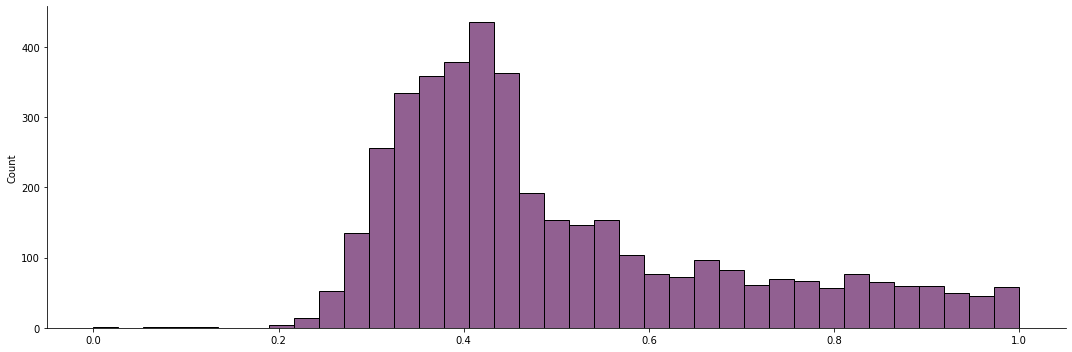

## Bad Rate and KS analysis

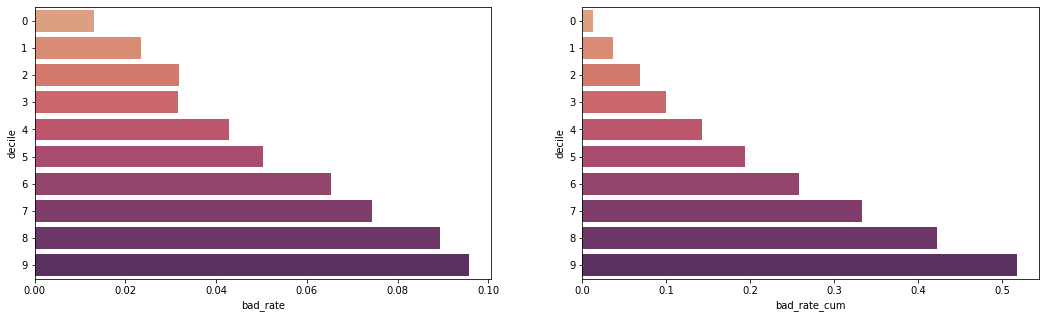

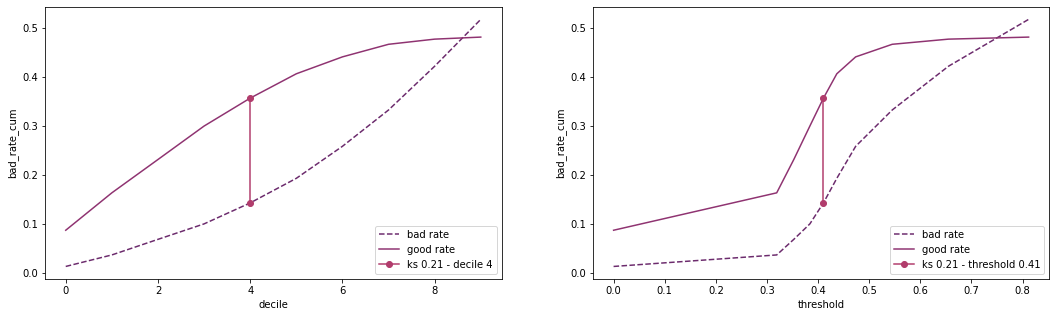

## ROC/PR Curve & AUC 

However, ROC curves can present an overly optimistic view of an algorithm’s performance if there is a large skew in the class distribution. […] Precision-Recall (PR) curves, often used in Information Retrieval , have been cited as an alternative to ROC curves for tasks with a large skew in the class distribution.

auc >= 80, which is a good Rate


In [271]:
model.fit(X_train,y_train)
y_proba = model.predict_proba(X_test)[:,1]
res = ModelMetrics(y_proba,y_test)

In [272]:
359/409

0.8777506112469438

In [273]:
res["deciles_df"]

level_0  decile  true  contagem  index  threshold  false  bad_prob  \
0        0       0    53       408      0   0.000000    355  0.129902   
1        1       1    96       408      1   0.319123    312  0.235294   
2        2       2   130       408      2   0.352556    278  0.318627   
3        3       3   129       408      3   0.383994    279  0.316176   
4        4       4   175       408      4   0.410571    233  0.428922   
5        5       5   205       408      5   0.436697    203  0.502451   
6        6       6   267       408      6   0.473583    141  0.654412   
7        7       7   303       408      7   0.545107    105  0.742647   
8        8       8   365       408      8   0.655167     43  0.894608   
9        9       9   391       408      9   0.811968     17  0.958333   

   good_prob       wof  ...  bad_rate_cum  good_rate_cum        ks  \
0   0.870098  1.901826  ...      0.012990       0.087010  0.074020   
1   0.764706  1.178655  ...      0.036520       0.163480  0.126961   
2   0.681373  0.760087  ...      0.068382       0.231618  0.163235   
3   0.683824  0.771399  ...      0.100000       0.300000  0.200000   
4   0.571078  0.286252  ...      0.142892       0.357108  0.214216   
5   0.497549 -0.009804  ...      0.193137       0.406863  0.213725   
6   0.345588 -0.638489  ...      0.258578       0.441422  0.182843   
7   0.257353 -1.059772  ...      0.332843       0.467157  0.134314   
8   0.105392 -2.138697  ...      0.422304       0.477696  0.055392   
9   0.041667 -3.135494  ...      0.518137       0.481863  0.036275   

   specificity  sensitivity  precision  f1_score  threshold  peak_precision  \
0     1.000000     1.000000   0.518137  0.682596   0.000000        1.518137   
1     0.819430     0.974929   0.561275  0.712409   0.319123        1.380705   
2     0.660732     0.929518   0.602022  0.730755   0.352556        1.262755   
3     0.519329     0.868023   0.642507  0.738431   0.383994        1.161836   
4     0.377416     0.807001   0.696895  0.747918   0.410571        1.074311   
5     0.258901     0.724219   0.750490  0.737121   0.436697        1.009392   
6     0.155646     0.627247   0.812500  0.707955   0.473583        0.968146   
7     0.083927     0.500946   0.865196  0.634512   0.545107        0.949123   
8     0.030519     0.357616   0.926471  0.516041   0.655167        0.956989   
9     0.008647     0.184957   0.958333  0.310071   0.811968        0.966980   

   peak_sensitivity  
0          0.000000  
1          0.155499  
2          0.268785  
3          0.348694  
4          0.429585  
5          0.465318  
6          0.471601  
7          0.417019  
8          0.327097  
9          0.176310  

[10 rows x 22 columns]

## Random Forest

In [237]:
from sklearn.ensemble import RandomForestClassifier

In [238]:
model = RandomForestClassifier()

## proba distribution

<Figure size 1440x360 with 0 Axes>

## Bad Rate and KS analysis

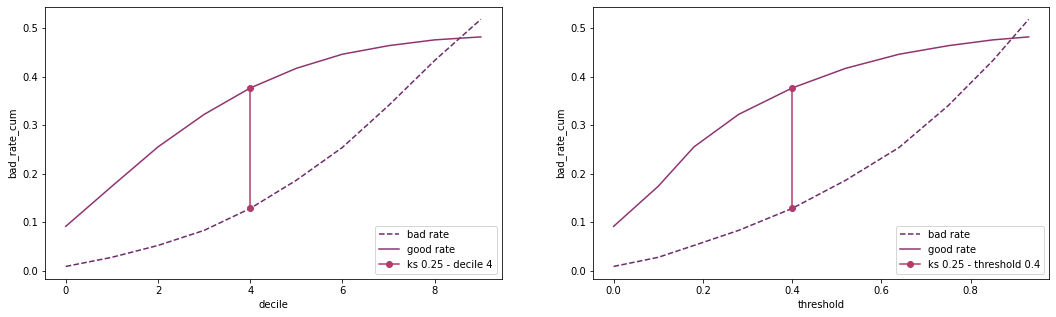

## ROC/PR Curve & AUC 

However, ROC curves can present an overly optimistic view of an algorithm’s performance if there is a large skew in the class distribution. […] Precision-Recall (PR) curves, often used in Information Retrieval , have been cited as an alternative to ROC curves for tasks with a large skew in the class distribution.

auc >= 80, which is a good Rate


In [239]:
model.fit(X_train,y_train)
y_proba = model.predict_proba(X_test)[:,1]
res = ModelMetrics(y_proba,y_test)

## gradient boosting

In [240]:
from sklearn.ensemble import GradientBoostingClassifier

In [241]:
model = GradientBoostingClassifier()

## proba distribution

<Figure size 1440x360 with 0 Axes>

## Bad Rate and KS analysis

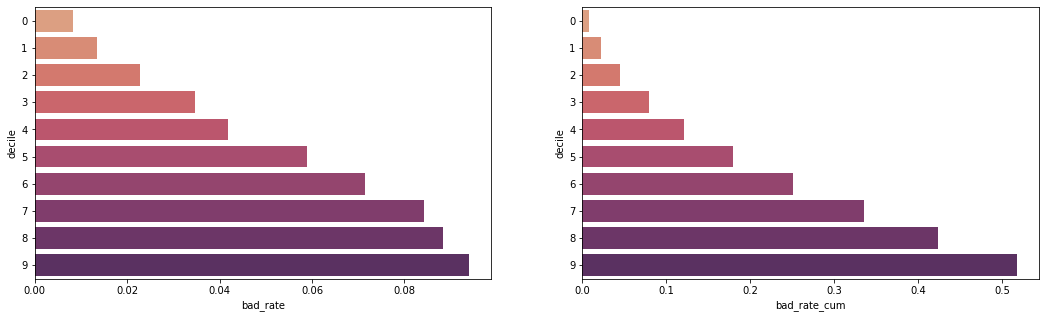

## ROC/PR Curve & AUC 

However, ROC curves can present an overly optimistic view of an algorithm’s performance if there is a large skew in the class distribution. […] Precision-Recall (PR) curves, often used in Information Retrieval , have been cited as an alternative to ROC curves for tasks with a large skew in the class distribution.

auc >= 80, which is a good Rate


In [243]:
model.fit(X_train,y_train)
y_proba = model.predict_proba(X_test)[:,1]
res = ModelMetrics(y_proba,y_test, 10)